In [81]:
using JLD2
# using PythonPlot
include("MDPModelFunctions2.jl")
using DataFrames
using ImageFiltering
include("setupPythonPlot.jl")
using Distributions
# using PyCall

In [2]:
function load_results(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = 1, on_cluster = false)
    
    if on_cluster
        to_save_folder = "/home/erussek/projects/Memory_Models/tanou_parameter_search"
    else
        to_save_folder = "/Users/erussek/Dropbox/Griffiths_Lab_Stuff/code/Memory_Models/tanou_parameter_search/exp$(exp_num)"
    end
    
    local file_name = "N_Quanta_$(N_Quanta)_epsilon_$(epsilon)_NT_per_Second_$(NT_per_Second)_memslope_$(mem_slope).jld2"
    
    local full_file_path = joinpath(to_save_folder,file_name)

    res = load(full_file_path)
    
    return res["job_res_$(exp_num)"]
end

load_results (generic function with 1 method)

In [4]:
## Specify parameters for each job...
# 21 epsilon values

NT_vals = [10, 25, 50, 100, 200, 400, 800] # run w these now... 

eps_vals = collect(1:-.02:.02) # 17
c_vals = round.(1 .- eps_vals, digits = 2)
N_eps = length(eps_vals)
# quanta values
q_vals = collect(2:1:50) # could go to one... 
N_q = length(q_vals)

mem_slopes = [.2]
N_ms = length(mem_slopes)

# re-run with new values so we can see some concavity...
N_nt = length(NT_vals)
N_hyp = N_nt

7

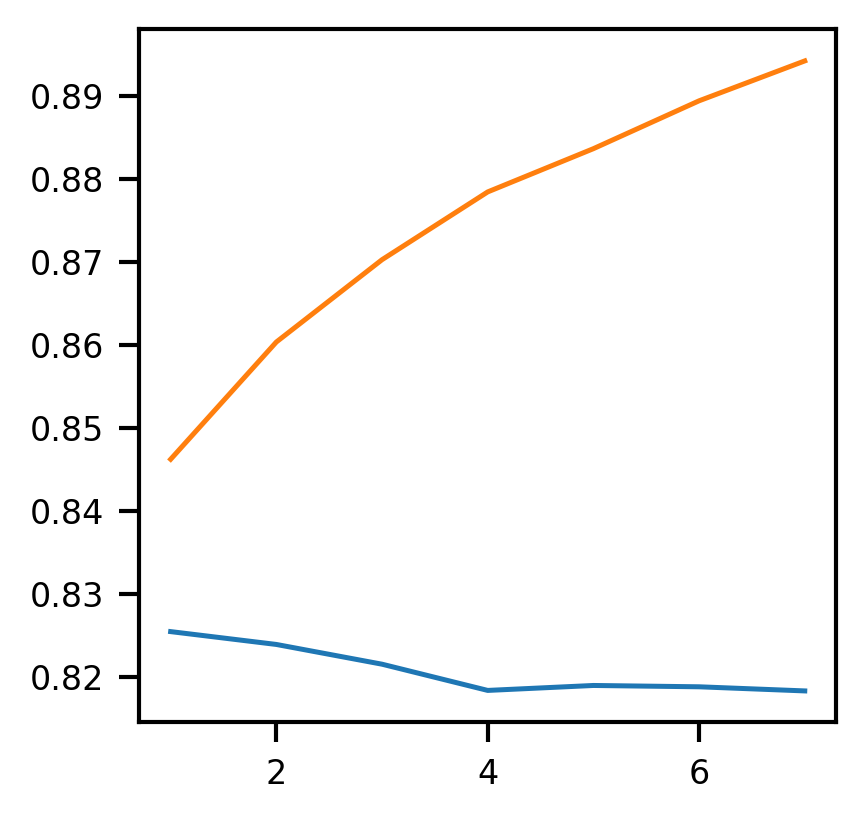

Python: [<matplotlib.lines.Line2D object at 0x2a3aa7830>]

In [5]:
eps_idx = 6
q_idx = 30
hyp_idx =5

epsilon = eps_vals[eps_idx]
N_Quanta = q_vals[q_idx]
NT_per_Second = NT_vals[hyp_idx]
mem_slope = .2#mem_slopes[hyp_idx]

these_res = load_results(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = 1, on_cluster = false)

p_neutral_res = these_res[1:7]
p_retro_res = these_res[8:14]
fig,ax = subplots(1,dpi=300, figsize=(3,3))
ax.plot(1:7, p_neutral_res)
ax.plot(1:7, p_retro_res, label = "")


#### Load the true res

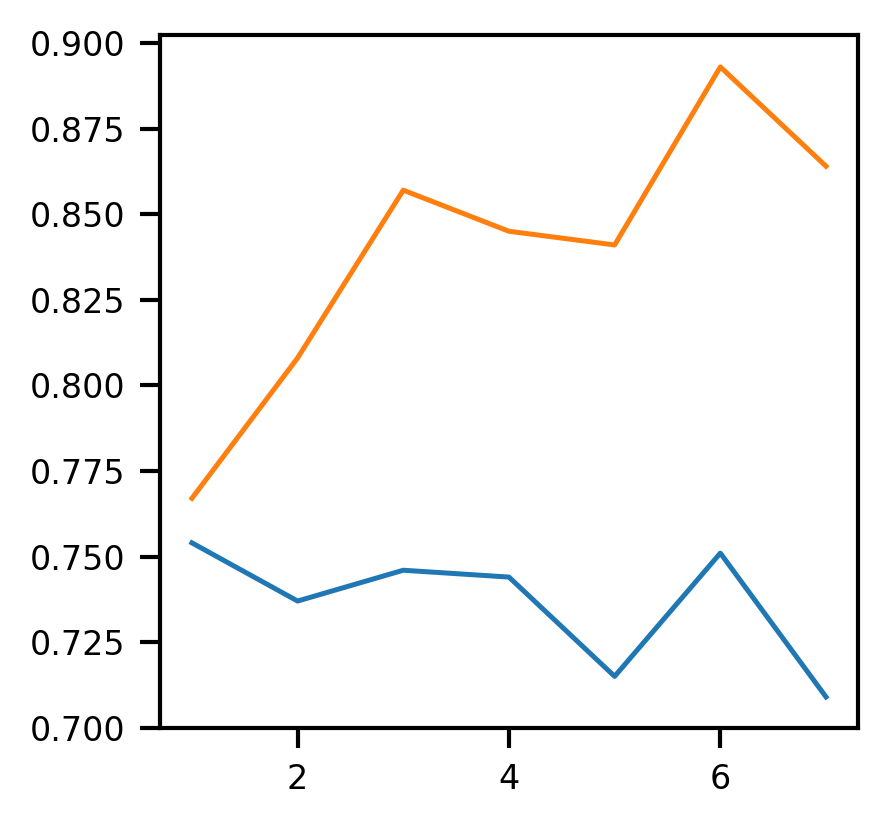

Python: [<matplotlib.lines.Line2D object at 0x2a3b4d6d0>]

In [6]:
true_neutral_res = [.754 .737 .746 .744 .715 .751 .709]'
true_retro_res = [.767 .808 .857 .845 .841 .893 .864]'
true_res = [true_neutral_res; true_retro_res];

fig,ax = subplots(1,dpi=300, figsize=(3,3))
ax.plot(1:7, true_neutral_res)
ax.plot(1:7, true_retro_res, label = "")


### Compute mean squared error for all parameter combinations...

In [7]:
these_res = load_results(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = 1, on_cluster = false)

14-element Vector{Float64}:
 0.8254459166598384
 0.8238979427773433
 0.8215190845591462
 0.8183586632025208
 0.8189552237609518
 0.8187960464275763
 0.8182989996114047
 0.846214470109094
 0.860343668682279
 0.8702623806232541
 0.8784305802017741
 0.8836398814207918
 0.8894073556310351
 0.8942156537701099

In [8]:

#for hyp_idx in 1:length(NT_vals)
mse_res = zeros(N_eps, N_q, N_nt)

for (ep_idx, epsilon) in enumerate(eps_vals)
    for (q_idx, N_Quanta) in enumerate(q_vals)
        for hyp_idx in 1:length(NT_vals)
            
            NT_per_Second = NT_vals[hyp_idx]
            mem_slope = .2#mem_slopes[hyp_idx]
            
            these_res = load_results(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = 1, on_cluster = false)
            
            this_mse = sum((these_res .- true_res).^2)
            mse_res[ep_idx, q_idx, hyp_idx] = this_mse
            
        end
    end
end



### Make MSE plot

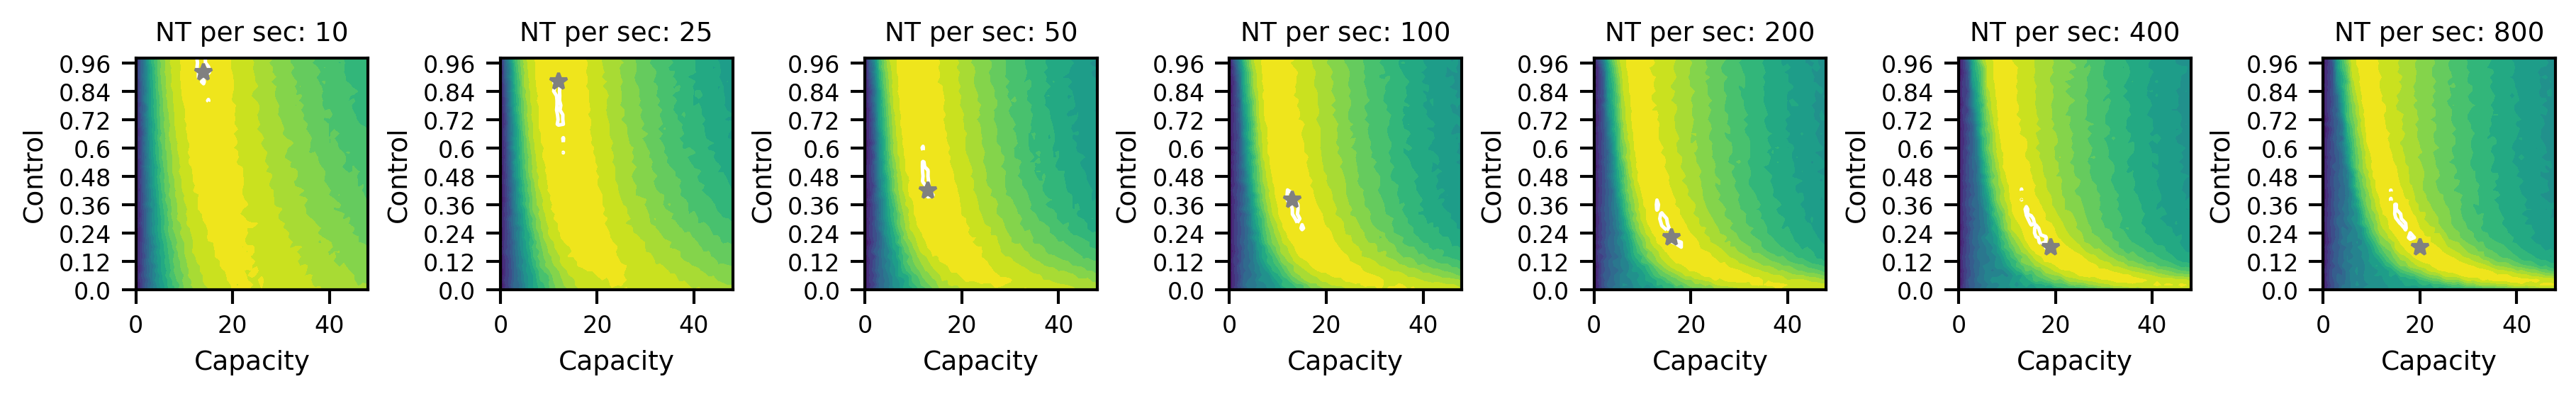

In [128]:
fig,ax = subplots(1,7,dpi=300, figsize=(12,1.75), constrained_layout = true)

hyp_info = Dict()

for hyp_idx_i = 1:N_nt
    # ax[hyp_idx-1].axis("equal")

    hyp_idx = hyp_idx_i 
    this_mse = mse_res[:,:,hyp_idx]
    ax[hyp_idx-1].contourf(-1*this_mse, levels = 20)
    this_val_5 = percentile(this_mse[:,:][:], .5)
    ax[hyp_idx-1].contour(this_mse[:,:], levels = [this_val_5],  colors = "w")


    lab_inc = 6

    ax[hyp_idx-1].set_yticks(0:lab_inc:N_eps-1)
    ax[hyp_idx-1].set_yticklabels(c_vals[1:lab_inc:N_eps])
    ax[hyp_idx-1].set_ylabel("Control")
    ax[hyp_idx-1].set_xlabel("Capacity")

    model_info = Dict()
    model_info["MSE"] = minimum(this_mse)
    best_pidx = argmin(this_mse)
    model_info["Eps"] = eps_vals[best_pidx[1]]
    model_info["Q"] = Int(q_vals[best_pidx[2]])

    ax[hyp_idx-1].plot(best_pidx[2]-1, best_pidx[1]-1, "*", ms = 6, color = "gray")
    ax[hyp_idx-1].set_title("NT per sec: $(NT_vals[hyp_idx])")
    
    hyp_info[hyp_idx] = model_info
    
end



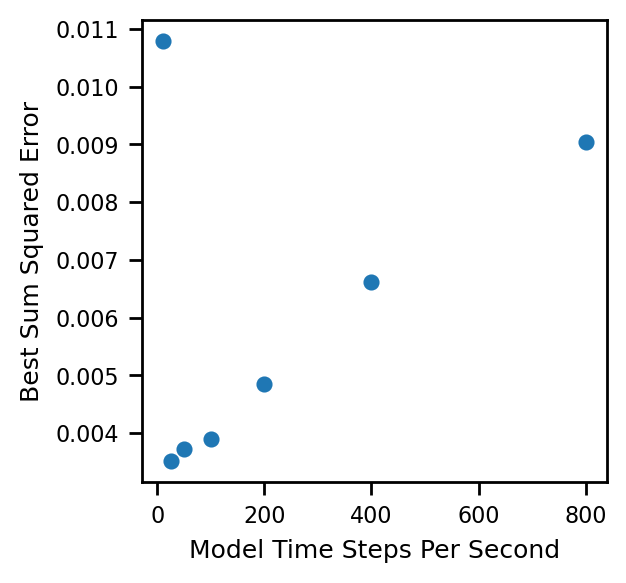

Python: Text(44.000000000000014, 0.5, 'Best Sum Squared Error')

In [126]:
hyp_info
best_mse_by_hyp = [hyp_info[i]["MSE"] for i in 1:7]
fig,ax = subplots(1, figsize=(3,3), dpi = 200)
ax.plot( NT_vals, best_mse_by_hyp, 'o')
ax.set_xlabel("Model Time Steps Per Second")
ax.set_ylabel("Best Sum Squared Error")

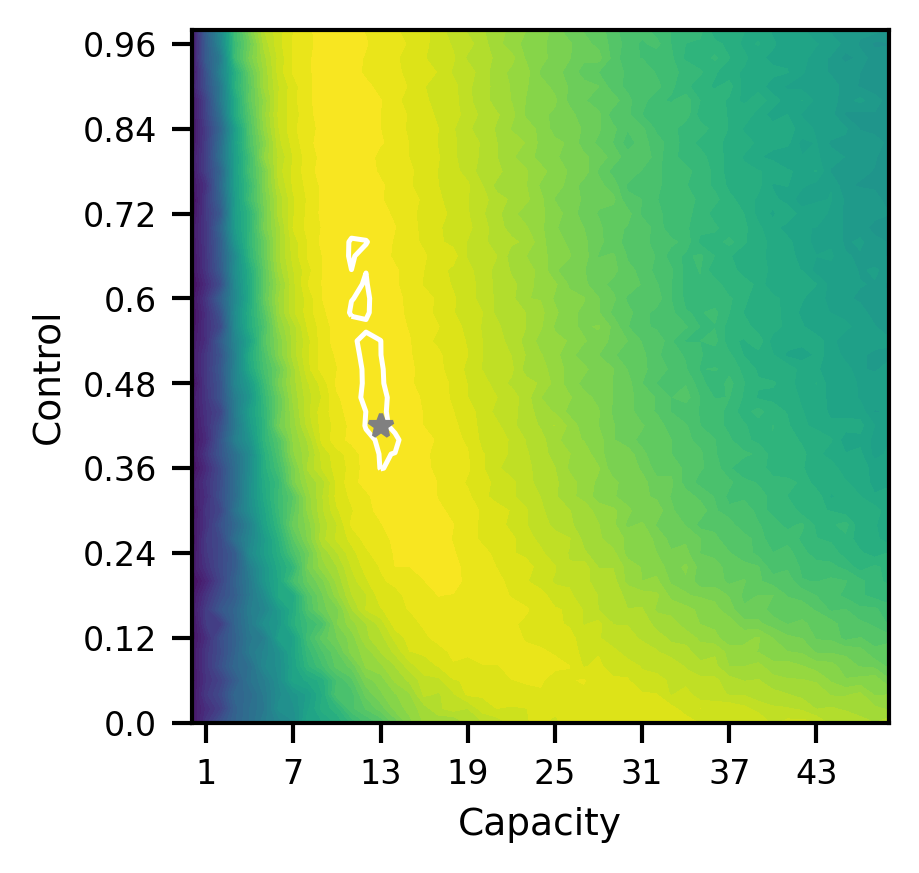

Python: [<matplotlib.lines.Line2D object at 0x2ab12daf0>]

In [11]:
fig,ax = subplots(1,figsize=(3,3), dpi=300)

hyp_idx_i = 3

start_q_idx = 1
end_q_idx = 49

#ax.axis("equal")

hyp_idx = hyp_idx_i 
this_mse = mse_res[:,start_q_idx:end_q_idx,hyp_idx]
ax.contourf(-1*this_mse, levels = 50)
this_val_5 = percentile(this_mse[:,:][:], 1)
ax.contour(this_mse[:,:], levels = [this_val_5],  colors = "w")


lab_inc = 6

ax.set_yticks(0:lab_inc:N_eps-1)
ax.set_yticklabels(c_vals[1:lab_inc:N_eps])
ax.set_ylabel("Control")
ax.set_xlabel("Capacity")
ax.set_xticks(start_q_idx:lab_inc:end_q_idx-1)
#ax.set_xticklabels(c_vals[1:lab_inc:N_eps])
model_info = Dict()
model_info["MSE"] = minimum(this_mse)
best_pidx = argmin(this_mse)
model_info["Eps"] = eps_vals[best_pidx[1]]
model_info["Q"] = Int(q_vals[best_pidx[2]])

ax.plot(best_pidx[2]-1, best_pidx[1]-1, "*", ms = 6, color = "gray")

# hyp_info[hyp_idx] = model_info

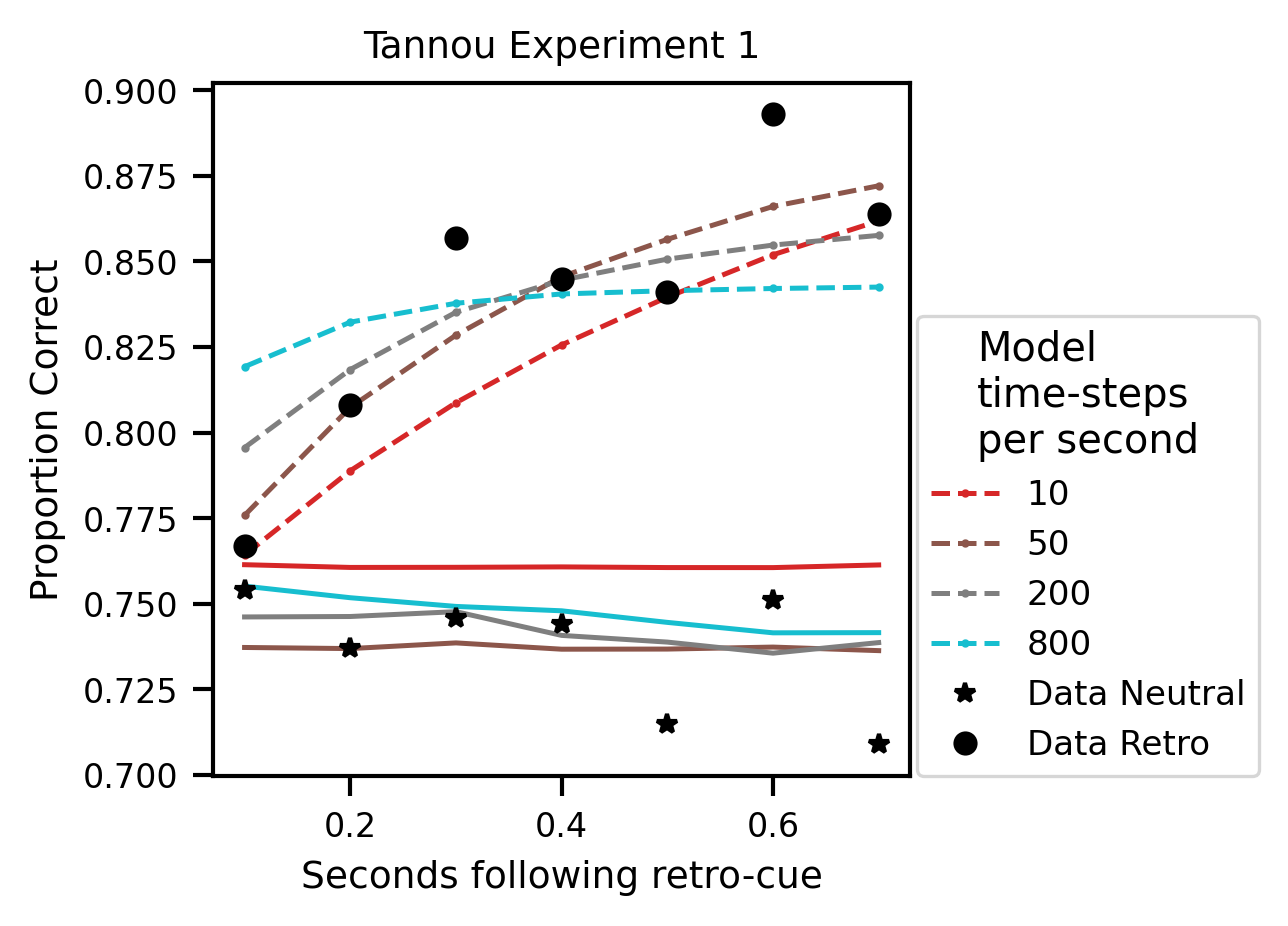

Python: Text(0.5, 1.0, 'Tannou Experiment 1')

In [13]:
fig,ax = subplots(1,dpi=300, figsize=(3,3))

time_vals = .1:.1:.7


for hyp_idx = 1:2:7
    
    NT_per_Second = NT_vals[hyp_idx]
    
    model_info = hyp_info[hyp_idx]
    
    # can you run the whole thing...
    best_model_res = load_results(model_info["Eps"], model_info["Q"], NT_per_Second, mem_slope; exp_num = 1, on_cluster = false)
    best_neutral_res = best_model_res[1:7]# + .01*randn(7)
    best_retro_res = best_model_res[8:14]# + .01*randn(7)

    ax.plot(time_vals, best_neutral_res, color = string.("C", hyp_idx+2))
    ax.plot(time_vals, best_retro_res, "--o", ms = 1, label = NT_vals[hyp_idx], color = string.("C", hyp_idx+2))

end

ax.plot(time_vals, true_neutral_res, "k*", label = "Data Neutral")
ax.plot(time_vals, true_retro_res, "ko", label = "Data Retro")
ax.set_xlabel("Seconds following retro-cue")
ax.set_ylabel("Proportion Correct")
ax.legend(loc=(1.01,0), title = "Model\ntime-steps\nper second")
ax.set_title("Tannou Experiment 1")

0.82
0.62
0.42
0.22
0.02
9
12
15
18
21


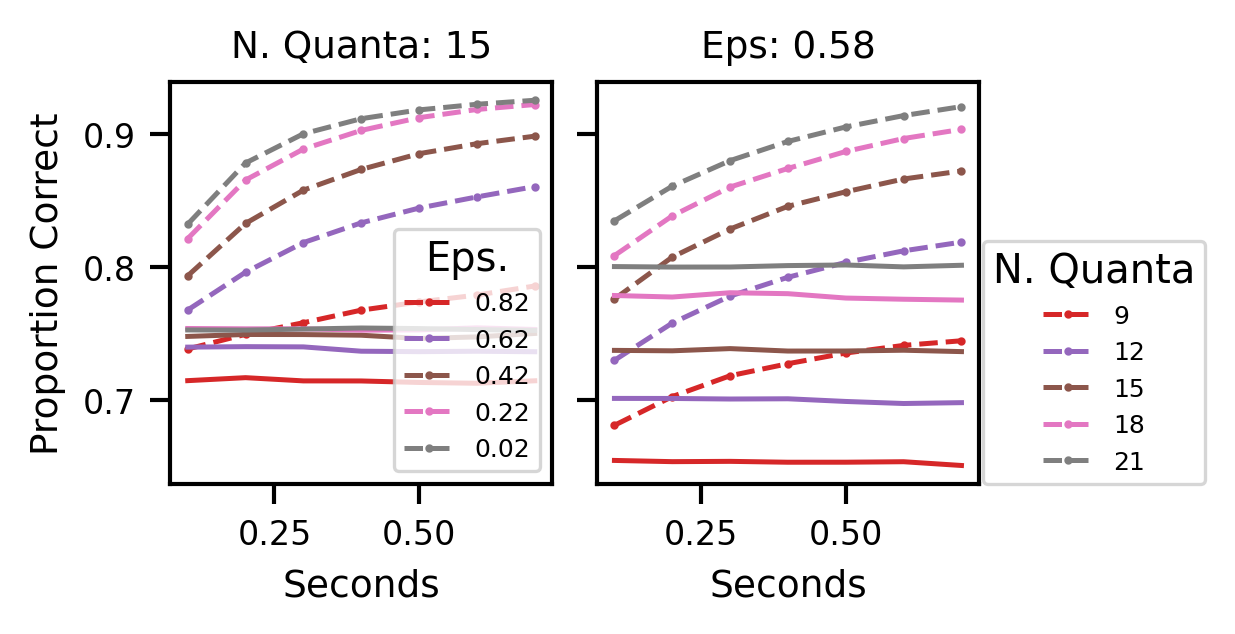

In [14]:
hyp_idx = 3
NT_per_Second = NT_vals[hyp_idx]

fig,ax = subplots(1,2,dpi=300, figsize=(4,2), sharey = true, constrained_layout = true)

model_info = hyp_info[hyp_idx]


time_vals = .1:.1:.7

for eps_idx = 1:5
    
    
    #this_eps_offset = round(.08*(eps_idx - 5), digits = 2)
    this_eps = eps_vals[10*eps_idx]
    println(this_eps)
    best_model_res = load_results(round(this_eps, digits = 2) , model_info["Q"], NT_per_Second, mem_slope; exp_num = 1, on_cluster = false)
    best_neutral_res = best_model_res[1:7]# + .01*randn(7)
    best_retro_res = best_model_res[8:14] #+ .01*randn(7)
    
    ax[0].plot(time_vals, best_neutral_res, color = string.("C", eps_idx+2))
    ax[0].plot(time_vals, best_retro_res, "--o", ms = 1, label = this_eps, color = string.("C", eps_idx+2))
    ax[0].legend(title = "Eps.", fontsize=6)
    ax[0].set_title("N. Quanta: $(model_info["Q"])")
    ax[0].set_ylabel("Proportion Correct")
    ax[0].set_xlabel("Seconds")

    #ax[0].legend(fontsize=6)
    # ax[0].set_title()    
end

for q_idx = 1:5
    
    #this_eps_offset = round(.08*(eps_idx - 5), digits = 2)
    this_q = q_vals[3*q_idx + 5]
    println(this_q)
    best_model_res = load_results( model_info["Eps"] , this_q, NT_per_Second, mem_slope; exp_num = 1, on_cluster = false)
    best_neutral_res = best_model_res[1:7]# + .01*randn(7)
    best_retro_res = best_model_res[8:14] #+ .01*randn(7)
    
    ax[1].plot(time_vals, best_neutral_res, color = string.("C", q_idx+2))
    ax[1].plot(time_vals, best_retro_res, "--o", ms = 1, label = this_q, color = string.("C", q_idx+2))
    ax[1].legend(title = "N. Quanta", fontsize = 6, loc = (1.01, 0))
    ax[1].set_title("Eps: $(model_info["Eps"])")
    ax[1].set_xlabel("Seconds")
    
end

In [17]:
size(these_res)

(14,)

In [18]:
all_res = zeros(N_eps, N_q, 14)

for (ep_idx, epsilon) in enumerate(eps_vals)
    for (q_idx, N_Quanta) in enumerate(q_vals)

            NT_per_Second = NT_vals[hyp_idx]
            mem_slope = .2#mem_slopes[hyp_idx]

            these_res = load_results(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = 1, on_cluster = false)
            all_res[ep_idx, q_idx,:] = these_res

            #this_mse = sum((these_res .- data).^2)
            #mse_res[ep_idx, q_idx] = this_mse

    end
end

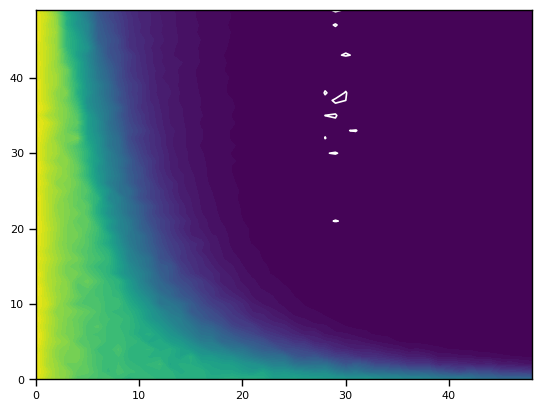

Python: <matplotlib.contour.QuadContourSet object at 0x2bed094c0>

In [178]:
#### try to do parameter recovery.

function compute_mse(data, NT_per_Second, mem_slope, all_res)

    #for hyp_idx in 1:length(NT_vals)
    mse_res = zeros(N_eps, N_q)

    for (ep_idx, epsilon) in enumerate(eps_vals)
        for (q_idx, N_Quanta) in enumerate(q_vals)

                NT_per_Second = NT_vals[hyp_idx]
                mem_slope = .2#mem_slopes[hyp_idx]

                these_res = all_res[ep_idx, q_idx, :]#load_results(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = 1, on_cluster = false)

                this_mse = sum((these_res .- data).^2)
                mse_res[ep_idx, q_idx] = this_mse

        end
    end
    return mse_res
end


eps_idx = 50
q_idx = 30
hyp_idx = 7
mem_slope = .2

true_epsilon = eps_vals[eps_idx]
true_Nq = q_vals[q_idx]
NT_per_Second = NT_vals[hyp_idx]

# 
sim_data = load_results( true_epsilon , true_Nq, NT_per_Second, mem_slope; exp_num = 1, on_cluster = false)

this_mse = compute_mse(sim_data, NT_per_Second, mem_slope)

model_info = Dict()
model_info["MSE"] = minimum(this_mse)
best_pidx = argmin(this_mse)
fitted_epsilon = eps_vals[best_pidx[1]]
fitted_Nq = Int(q_vals[best_pidx[2]])




# get the best vals

fig,ax = subplots()
ax.contourf(this_mse, levels = 60)
this_val_5 = percentile(this_mse[:,:][:], .5)
ax.contour(this_mse[:,:], levels = [this_val_5],  colors = "w")

In [170]:

function generate_param_recov(N_trials)

    hyp_idx = 7
    mem_slope = .2

    true_eps_all = zeros(N_eps, N_q)
    true_Nq_all = zeros(N_eps, N_q)
    fitted_eps_all = zeros(N_eps, N_q)
    fitted_Nq_all = zeros(N_eps, N_q)
    # N_trials = 10000


    for eps_idx = 1:N_eps
        print(eps_idx)
        for q_idx = 1:N_q


            true_epsilon = eps_vals[eps_idx]
            true_Nq = q_vals[q_idx]
            NT_per_Second = NT_vals[hyp_idx]

            # 
            sim_data = all_res[eps_idx, q_idx, :] #+ noise_param.*randn(14)#load_results(true_epsilon , true_Nq, NT_per_Second, mem_slope; exp_num = 1, on_cluster = false)


            sim_data_sample = [rand(Binomial(N_trials,x)) / N_trials for x in sim_data]

            this_mse = compute_mse(sim_data_sample, NT_per_Second, mem_slope, all_res)
            #this_mse[eps_idx,q_idx] = 100

            model_info = Dict()
            model_info["MSE"] = minimum(this_mse)
            best_pidx = argmin(this_mse)
            fitted_epsilon = eps_vals[best_pidx[1]]
            fitted_Nq = Int(q_vals[best_pidx[2]])

            true_eps_all[eps_idx, q_idx] = true_epsilon
            true_Nq_all[eps_idx, q_idx] = true_Nq
            fitted_eps_all[eps_idx, q_idx] = fitted_epsilon
            fitted_Nq_all[eps_idx, q_idx] = fitted_Nq



        end
    end

    return DataFrame(true_eps = true_eps_all[:], true_Nq = true_Nq_all[:], fitted_eps = fitted_eps_all[:], fitted_Nq = fitted_Nq_all[:])
    
end

generate_param_recov (generic function with 1 method)

In [138]:
N_trial_vals

1-element Vector{StepRange{Int64, Int64}}:
 5:10:95

In [171]:


N_trial_vals = [5,10,20,40,80,160,320]
eps_corr = zeros(length(N_trial_vals))
nq_corr = zeros(length(N_trial_vals))
fitted_corr=zeros(length(N_trial_vals))

for (n_trial_idx, n_trials) in enumerate(N_trial_vals)
    p_df = generate_param_recov(n_trials)
    eps_corr[n_trial_idx] = round(cor(p_df[!,:true_eps], p_df[!,:fitted_eps]),digits = 3)
    nq_corr[n_trial_idx] = round(cor(p_df[!,:true_Nq], p_df[!,:fitted_Nq]),digits = 3)
    fitted_corr[n_trial_idx] = round(cor(p_df[!,:fitted_eps], p_df[!,:fitted_Nq]),digits = 3)
end


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849501234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849501234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950

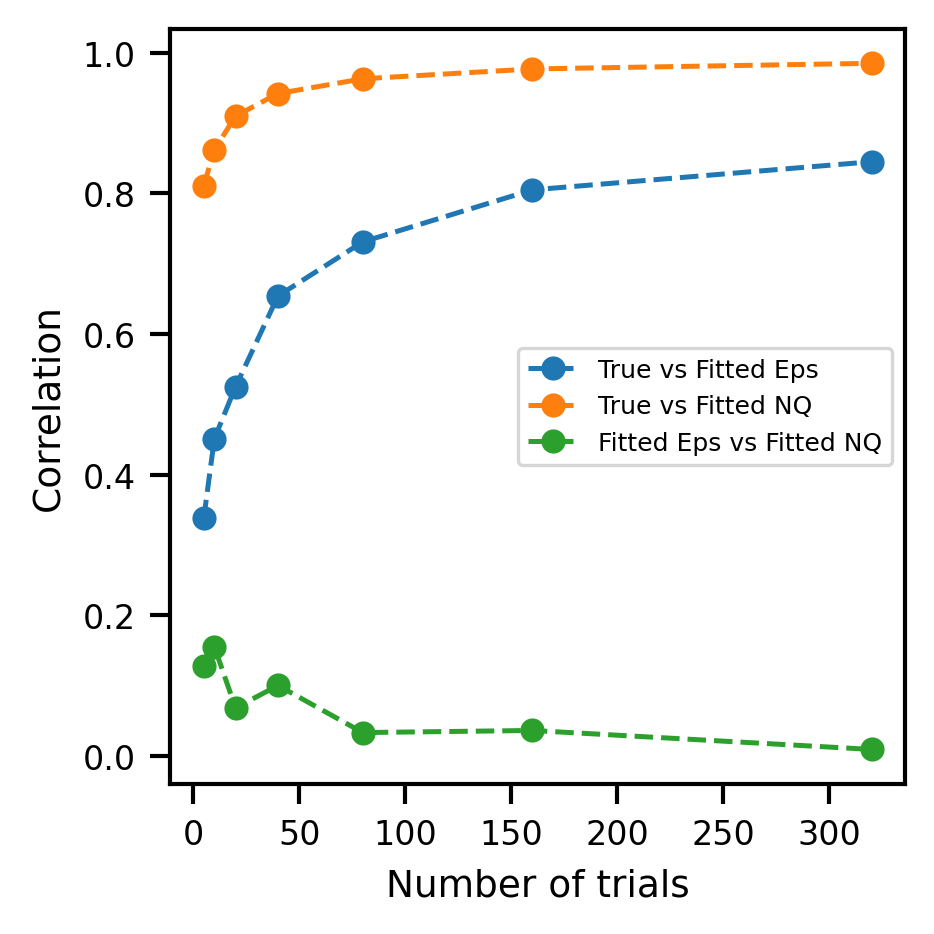

Python: Text(66.00000000000001, 0.5, 'Correlation')

In [172]:
fig,ax = subplots(1, figsize = (3,3), dpi=300, constrained_layout = true)
ax.plot(N_trial_vals, eps_corr, "--o", label = "True vs Fitted Eps")
ax.plot(N_trial_vals, nq_corr, "--o", label = "True vs Fitted NQ")
ax.plot(N_trial_vals, fitted_corr, "--o", label = "Fitted Eps vs Fitted NQ")

ax.set_xlabel("Number of trials")
ax.legend(fontsize=6)
ax.set_ylabel("Correlation")
ax.set_ylabel("Correlation")

In [179]:
param_search_df = generate_param_recov(1000)#DataFrame(true_eps = true_eps_all[:], true_Nq = true_Nq_all[:], fitted_eps = fitted_eps_all[:], fitted_Nq = fitted_Nq_all[:])

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950

Row,true_eps,true_Nq,fitted_eps,fitted_Nq
,Float64,Float64,Float64,Float64
1,1.0,2.0,0.38,2.0
2,0.98,2.0,0.8,3.0
3,0.96,2.0,0.6,3.0
4,0.94,2.0,0.72,2.0
5,0.92,2.0,0.38,2.0
6,0.9,2.0,0.26,2.0
7,0.88,2.0,0.36,2.0
8,0.86,2.0,0.96,2.0
9,0.84,2.0,0.48,2.0


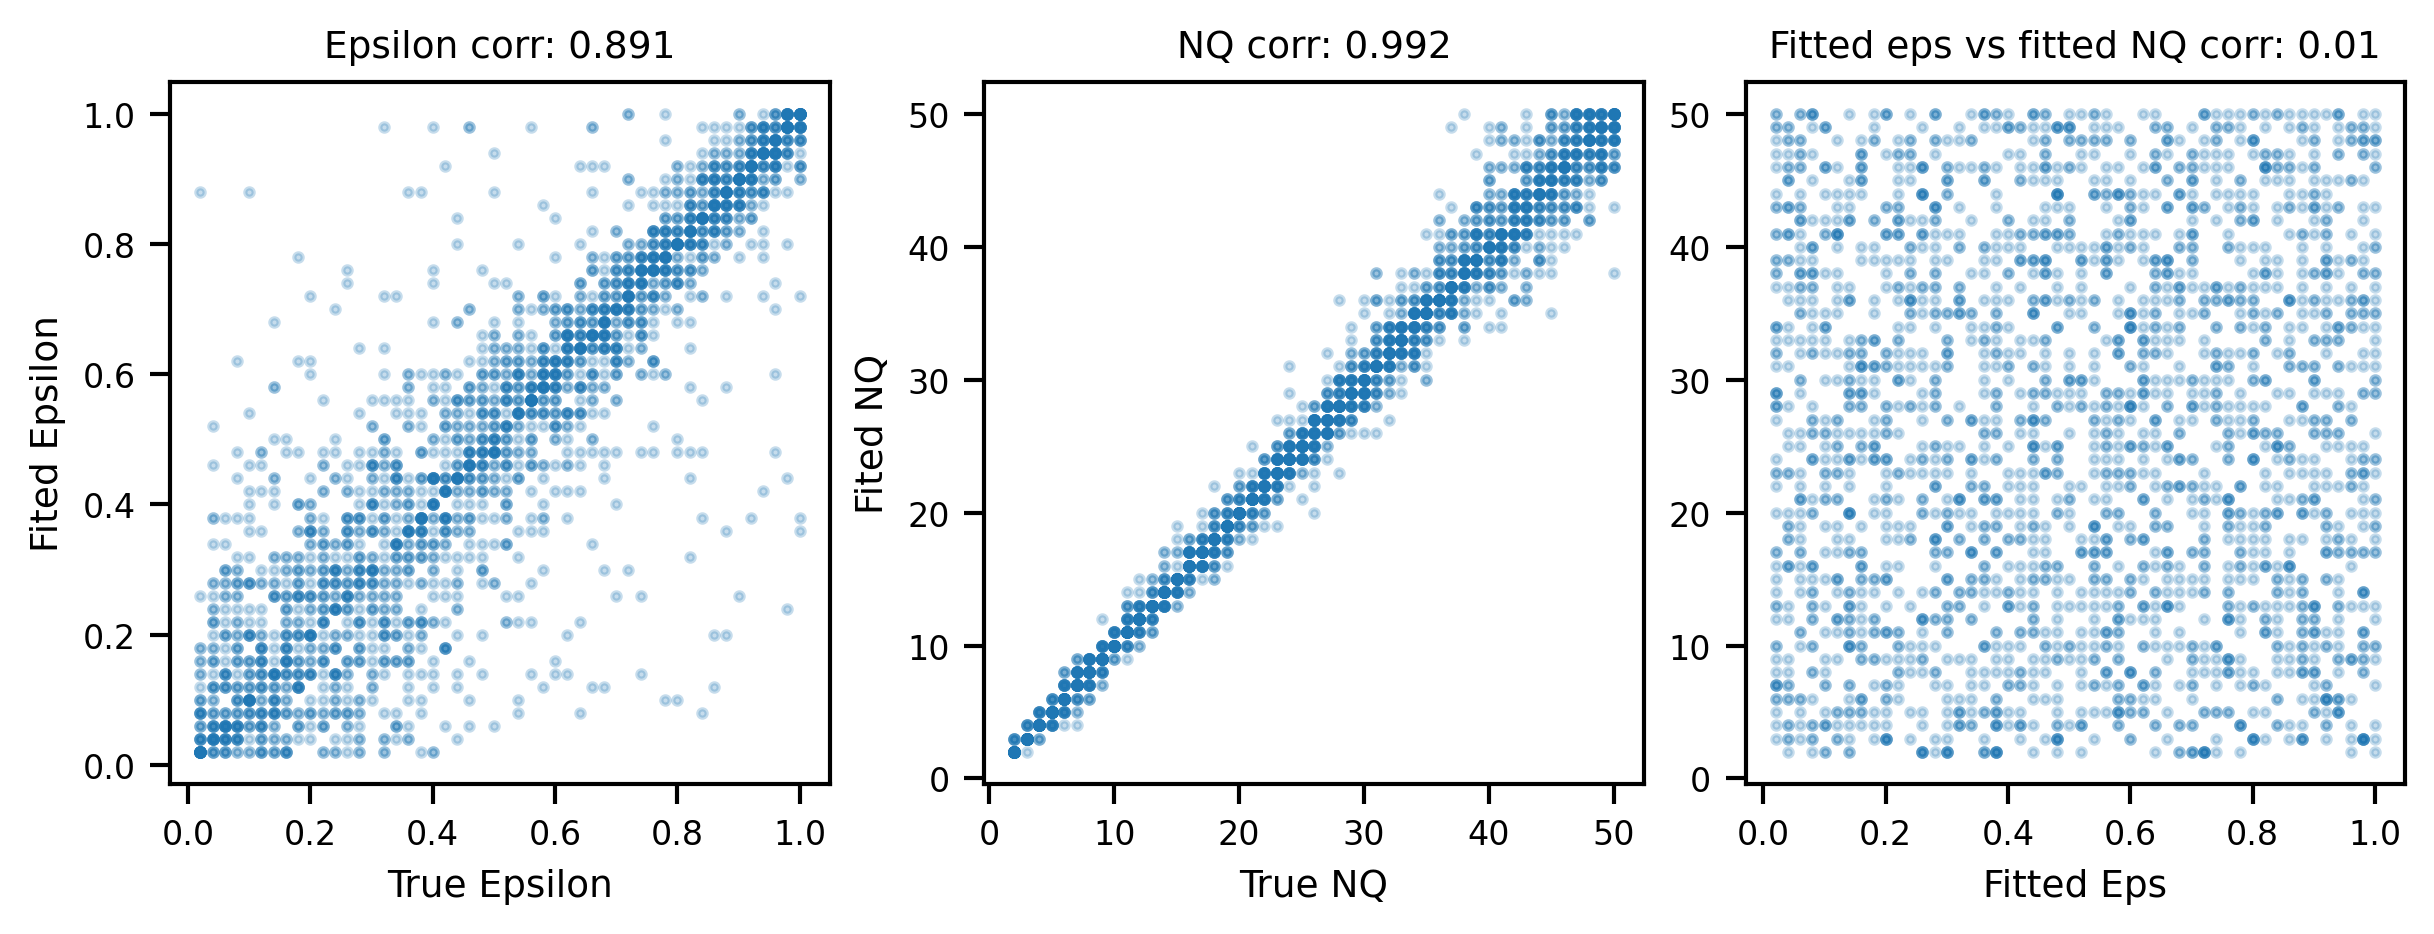

Python: Text(0.5, 65.99999999999999, 'Fitted Eps')

In [180]:
fig,ax = subplots(1,3,figsize = (8,3), dpi=300, constrained_layout = true)
ax[0].plot(param_search_df[!,:true_eps], param_search_df[!,:fitted_eps], "o",  alpha = .25, ms = 2)
eps_corr = round(cor(param_search_df[!,:true_eps], param_search_df[!,:fitted_eps]),digits = 3)
ax[0].set_title("Epsilon corr: $(eps_corr)")
ax[0].set_xlabel("True Epsilon")
ax[0].set_ylabel("Fited Epsilon")


ax[1].plot(param_search_df[!,:true_Nq], param_search_df[!,:fitted_Nq], "o",  alpha = .25, ms = 2)
Nq_corr = round(cor(param_search_df[!,:true_Nq], param_search_df[!,:fitted_Nq]),digits = 3)
ax[1].set_title("NQ corr: $(Nq_corr)")
ax[1].set_xlabel("True NQ")
ax[1].set_ylabel("Fited NQ")

ax[2].plot(param_search_df[!,:fitted_eps], param_search_df[!,:fitted_Nq], "o", alpha = .25, ms = 2)
fit_corr = round(cor(param_search_df[!,:fitted_eps], param_search_df[!,:fitted_Nq]),digits = 3)
ax[2].set_title("Fitted eps vs fitted NQ corr: $(fit_corr)")
ax[2].set_title("Fitted eps vs fitted NQ corr: $(fit_corr)")
ax[2].set_xlabel("Fitted Eps")

In [99]:
N_trials = 1000

[rand(Binomial(N_trials,x)) / N_trials for x in sim_data]

14-element Vector{Float64}:
 0.947
 0.959
 0.95
 0.943
 0.946
 0.956
 0.961
 0.962
 0.968
 0.977
 0.977
 0.975
 0.982
 0.982

In [92]:
rand(Binomial(N_trials,sim_data[1]))

18

In [94]:
sim_data

14-element Vector{Float64}:
 0.9539869699700331
 0.9293847783703636
 0.918526995798774
 0.9695857253510698
 0.9189830834210673
 0.9768121029873563
 0.95043942494467
 0.9377928448232371
 0.9390643821723988
 1.0075822197237432
 0.9758418218335109
 0.9403734037102264
 0.9861948303977603
 0.9600530731800349

In [167]:
model_info

Dict{Any, Any} with 3 entries:
  "Q"   => 14
  "MSE" => 0.00352044
  "Eps" => 0.12

In [127]:
this_eps_offset = round(.02*(eps_idx - 3), digits = 2)

model_info["Eps"] + this_eps_offset 

0.6399999999999999

In [128]:
this_eps_offset

0.06

In [129]:
model_info["Eps"]

0.58

In [ ]:

these_res = load_results(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = 1, on_cluster = false)


In [74]:
hyp_info

Dict{Any, Any} with 5 entries:
  5 => Dict{Any, Any}("Q"=>18, "MSE"=>0.00484845, "Eps"=>0.78)
  4 => Dict{Any, Any}("Q"=>15, "MSE"=>0.0038949, "Eps"=>0.62)
  2 => Dict{Any, Any}("Q"=>14, "MSE"=>0.00352044, "Eps"=>0.12)
  3 => Dict{Any, Any}("Q"=>15, "MSE"=>0.00371786, "Eps"=>0.58)
  1 => Dict{Any, Any}("Q"=>16, "MSE"=>0.0107933, "Eps"=>0.08)

In [54]:
hyp_idx = 3
model_info = hyp_info[hyp_idx]

sim_tanoue_exp1(epsilon + .-2, N_Quanta, NT_per_Second; mem_slope = .1, return_last_only=true, N_Trials = 1000)


"C1"